# Etude théorique et pratique de la génération d'images adverses à partir de la bibliothèque foolbox

## Importation des librairies

In [ ]:
!pip3 install foolbox

     |████████████████████████████████| 1.7MB 17.9MB/s 
     |████████████████████████████████| 163kB 51.9MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import os 
import git
import foolbox as fb
import torch
import torchvision.models as models
import eagerpy as ep
from torch import tensor
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from foolbox.distances import Distance
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Mise en place du modèle

In [ ]:
# Modèle Tensorflow : RestNet 50
model = tf.keras.applications.ResNet50(weights="imagenet")

# Centrer et réduire
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])

# Intégrer le modèle foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0,255), preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0, 1))

102973440/102967424 [==============================] - 1s 0us/step
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


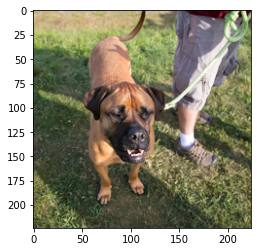

In [ ]:
# Chargement des images et des labels non perturbés
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=20)
plt.imshow(images[0])

In [ ]:
# Précision du modèle
print('Précision du modèle sans perturbation :', fb.utils.accuracy(fmodel, images, labels)*100, '%')

Précision du modèle sans perturbation : 89.99999761581421 %


## Mise en place du scénario d'attaque pour FGSM en L2 et Linf


In [ ]:
# Facteurs d'intensité d'attaque à tester
epsilons = [0, 0.0002, 0.0005, 0.0008, 0.001, 0.0015, 0.002, 0.003, 0.006, 0.01, 0.1, 0.3, 0.5, 1.0]

In [ ]:
# Attaque 1 de type Gradient : FGSM avec la norme infinie 
attackFGSM = fb.attacks.LinfFastGradientAttack()
raw_advsFGSM, clipped_advsFGSM, successFGSM = attackFGSM(fmodel, images, labels, epsilons=epsilons)

In [ ]:
# Attaque 1 de type Gradient : FGSM avec la norme 2
attackFGSML2 = fb.attacks.L2FastGradientAttack()
raw_advsFGSML2, clipped_advsFGSML2, successFGSML2 = attackFGSML2(fmodel, images, labels, epsilons=epsilons)

- clipped_advs : images perturbées 
- success : résultat de classification si trop de perturbation l'image est mal classée, mais pas forcément assimilée comme une image attaquée

In [ ]:
successFGSM_numpy = successFGSM.numpy()
successFGSML2_numpy = successFGSML2.numpy() 

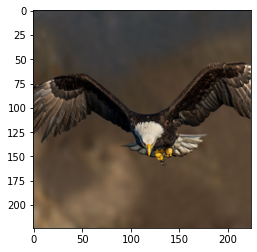

In [ ]:
plt.imshow(clipped_advsFGSM[0][17])
plt.show()

## Robustesse du modèle en fonction du facteur de perturbation epsilon pour FGSM en L2 et Linf

In [ ]:
# Plus l'algorithme est robuste, moins l'attaque est efficace

robustesseFGSM = 1 - successFGSM_numpy.mean(axis=-1)
robustesseFGSML2 = 1 - successFGSML2_numpy.mean(axis=-1)

print("Robustesse du modèle en fonction de l'intensité de l'attaque FGSM (Linf) :")
for eps, moy in zip(epsilons, robustesseFGSM):
    print(f"  Epsilon  = {eps:<6} : Robustesse du modèle = {moy.item() * 100:4.1f} %")

print()
print("Robustesse du modèle en fonction de l'intensité de l'attaque FGSM (L2) :")
for eps, moy in zip(epsilons, robustesseFGSML2):
    print(f"  Epsilon  = {eps:<6} : Robustesse du modèle = {moy.item() * 100:4.1f} %")

Robustesse du modèle en fonction de l'intensité de l'attaque FGSM (Linf) :
  Epsilon  = 0      : Robustesse du modèle = 90.0 %
  Epsilon  = 0.0002 : Robustesse du modèle = 90.0 %
  Epsilon  = 0.0005 : Robustesse du modèle = 75.0 %
  Epsilon  = 0.0008 : Robustesse du modèle = 60.0 %
  Epsilon  = 0.001  : Robustesse du modèle = 55.0 %
  Epsilon  = 0.0015 : Robustesse du modèle = 45.0 %
  Epsilon  = 0.002  : Robustesse du modèle = 40.0 %
  Epsilon  = 0.003  : Robustesse du modèle = 15.0 %
  Epsilon  = 0.006  : Robustesse du modèle =  5.0 %
  Epsilon  = 0.01   : Robustesse du modèle =  5.0 %
  Epsilon  = 0.1    : Robustesse du modèle =  5.0 %
  Epsilon  = 0.3    : Robustesse du modèle =  0.0 %
  Epsilon  = 0.5    : Robustesse du modèle =  0.0 %
  Epsilon  = 1.0    : Robustesse du modèle =  0.0 %

Robustesse du modèle en fonction de l'intensité de l'attaque FGSM (L2) :
  Epsilon  = 0      : Robustesse du modèle = 90.0 %
  Epsilon  = 0.0002 : Robustesse du modèle = 90.0 %
  Epsilon  = 0.0005

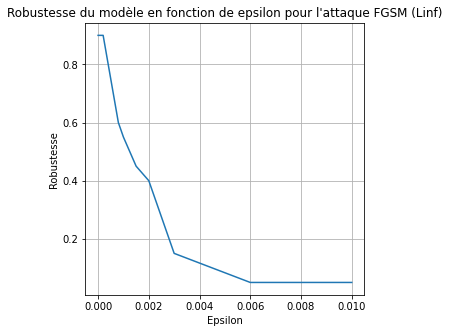

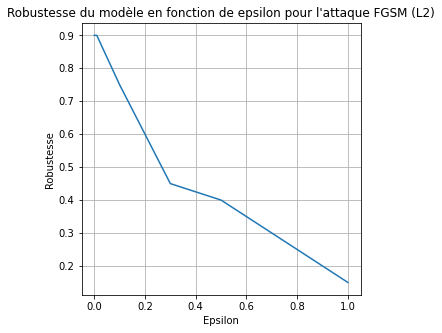

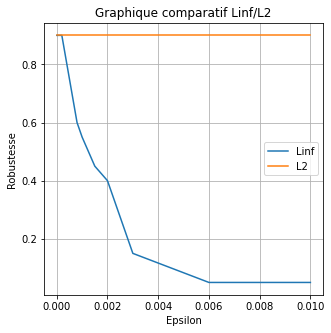

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:10], robustesseFGSM[:10], c='C00')
plt.grid(b=True)
plt.title("Robustesse du modèle en fonction de epsilon pour l'attaque FGSM (Linf)")
plt.xlabel("Epsilon")
plt.ylabel("Robustesse")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(epsilons[:14], robustesseFGSML2[:14], c='C00')
plt.grid(b=True)
plt.title("Robustesse du modèle en fonction de epsilon pour l'attaque FGSM (L2)")
plt.xlabel("Epsilon")
plt.ylabel("Robustesse")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(epsilons[:10], robustesseFGSM[:10])
plt.plot(epsilons[:10], robustesseFGSML2[:10])
plt.title("Graphique comparatif Linf/L2")
plt.xlabel("Epsilon")
plt.ylabel("Robustesse")
plt.grid(b=True)
plt.legend(['Linf', 'L2'], loc='right')
plt.show()


## Mise en place du scénario d'attaque pour Brendel and Bethge en Linf (différents steps) et robustesse du modèle

Bendel 20 Linf

In [ ]:
attack = fb.attacks.LinfinityBrendelBethgeAttack(steps=20)
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)
success_numpy = success.numpy()
robustesse = 1 - success_numpy.mean(axis=-1)

print("Robustesse du modèle en fonction de l'intensité de l'attaque Brendel and Bethge Linf Step=20 :")
for eps, moy in zip(epsilons, robustesse):
    print(f"  Epsilon  = {eps:<6} : Robustesse du modèle = {moy.item() * 100:4.1f} %")


Robustesse du modèle en fonction de l'intensité de l'attaque Brendel and Bethge Linf Step=20 :
  Epsilon  = 0      : Robustesse du modèle = 90.0 %
  Epsilon  = 0.0002 : Robustesse du modèle = 85.0 %
  Epsilon  = 0.0005 : Robustesse du modèle = 75.0 %
  Epsilon  = 0.0008 : Robustesse du modèle = 50.0 %
  Epsilon  = 0.001  : Robustesse du modèle = 40.0 %
  Epsilon  = 0.0015 : Robustesse du modèle = 30.0 %
  Epsilon  = 0.002  : Robustesse du modèle = 25.0 %
  Epsilon  = 0.003  : Robustesse du modèle = 25.0 %
  Epsilon  = 0.006  : Robustesse du modèle = 20.0 %
  Epsilon  = 0.01   : Robustesse du modèle = 15.0 %
  Epsilon  = 0.1    : Robustesse du modèle =  5.0 %
  Epsilon  = 0.3    : Robustesse du modèle =  5.0 %
  Epsilon  = 0.5    : Robustesse du modèle =  5.0 %
  Epsilon  = 1.0    : Robustesse du modèle =  0.0 %


Bendel 200 Linf

In [ ]:
attack1 = fb.attacks.LinfinityBrendelBethgeAttack(steps=200)
raw_advs1, clipped_advs1, success1 = attack1(fmodel, images, labels, epsilons=epsilons)
success_numpy1 = success1.numpy()
robustesse1 = 1 - success_numpy1.mean(axis=-1)

print("Robustesse du modèle en fonction de l'intensité de l'attaque Brendel and Bethge Linf Step=200 :")
for eps, moy in zip(epsilons, robustesse1):
    print(f"  Epsilon  = {eps:<6} : Robustesse du modèle = {moy.item() * 100:4.1f} %")


Bendel 500 Linf

In [ ]:
attack500 = fb.attacks.LinfinityBrendelBethgeAttack(steps=500)
raw_advs500, clipped_advs500, success500 = attack500(fmodel, images, labels, epsilons=epsilons)
success_numpy500 = success500.numpy()
robustesse500 = 1 - success_numpy500.mean(axis=-1)

print("Robustesse du modèle en fonction de l'intensité de l'attaque Brendel and Bethge Linf Step=500 :")
for eps, moy in zip(epsilons, robustesse2):
    print(f"  Epsilon  = {eps:<6} : Robustesse du modèle = {moy.item() * 100:4.1f} %")

Graphes

In [ ]:
plt.title('Brendel and Bethge Attack')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:8], robustesse[:8])
plt.plot(epsilons[:8], robustesse1[:8])
plt.plot(epsilons[:8], robustesse2[:8])
plt.legend(['Steps = 20', 'Steps = 200', 'Steps = 500'])
plt.grid(True)
plt.show()

plt.title('Brendel and Bethge Attack (Steps = 20)')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:8], robustesse[:8])
plt.grid(True)
plt.show()

plt.title('Brendel and Bethge Attack (Steps = 200)')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:8], robustesse1[:8])
plt.grid(True)
plt.show()

plt.title('Brendel and Bethge Attack (Steps = 500)')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:8], robustesse2[:8])
plt.grid(True)
plt.show()

In [ ]:
plt.imshow(clipped_advs1[0][0].numpy())

## Etude de la distorsion pour FGSM

In [ ]:
attackFGSM = fb.attacks.LinfFastGradientAttack()
raw_advsFGSM, clipped_advsFGSM, successFGSM = attackFGSM(fmodel, images, labels, epsilons=epsilons)

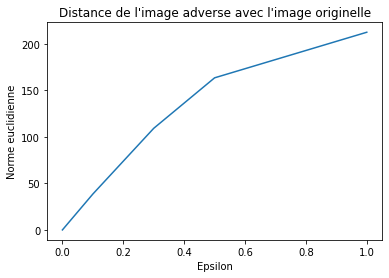

In [ ]:
DIST = []

for k in range(14) :
  D = clipped_advsFGSM[k][0]-images[0]
  d = tf.norm(D)
  DIST.append(d)
plt.plot(epsilons,DIST)
plt.title("Distance de l'image adverse avec l'image originelle")
plt.xlabel("Epsilon")
plt.ylabel("Norme euclidienne")
plt.show()

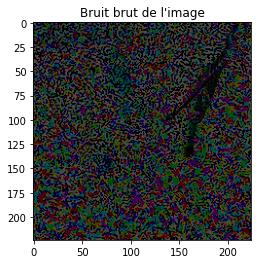

In [ ]:
plt.imshow(clipped_advsFGSM[11][0]-images[0])
plt.title("Bruit brut de l'image")
plt.show()

Graphe FGSM

In [ ]:
success_numpyFGSM = successFGSM.numpy()
robustesseFGSM = 1 - success_numpyFGSM.mean(axis=-1)
plt.title('FGSM')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:10], robustesseFGSM[:10])
plt.grid(True)
plt.show()


## Comparaison des deux attaques 

In [ ]:
attack500 = fb.attacks.LinfinityBrendelBethgeAttack(steps=500)
raw_advs500, clipped_advs500, success500 = attack500(fmodel, images, labels, epsilons=epsilons)
success_numpy500 = success500.numpy()
robustesse500 = 1 - success_numpy500.mean(axis=-1)

In [ ]:
plt.title('Brendel and Bethge (Steps = 500)')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:10], robustesse500[:10])
plt.grid(True)
plt.show()

In [ ]:
plt.title('Comparaison des deux attaques')
plt.xlabel('Epsilon')
plt.ylabel('Robustesse')
plt.plot(epsilons[:10], robustesse500[:10])
plt.plot(epsilons[:10], robustesseFGSM[:10])
plt.legend(['Brendel and Bethge', 'FGSM'])
plt.grid(True)
plt.show()